# Sequential MNIST
The sequential MNIST dataset can be found [here](https://edwin-de-jong.github.io/blog/mnist-sequence-data/). Essentially it turns the classic images into brush strokes giving each image as an array of dx and dy. This notebook uses an LSTM to detect the numbers and achieves 93.1% accuracy. I do not do any data augmentation which most likely is lowering the performance and definetly harms its real life usage (I wrote a simple script to draw and recognize numbers and the way I drew numbers mattered a lot - a 7 drawn in reverse was detected differently than a normally drawn 7).

## Imports

In [11]:
import os
import re

import torch

import numpy as np
import pandas as pd

from rich import print
from tqdm import tqdm

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt

torch.cuda.is_available()

True

## Data
To get the data, downlaod it from [here](https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/raw/master/sequences.tar.gz). After extracting it, it should all be in a folder called sequences. All of the images are labaled with `{train/test}img-{x}-inputdata.txt` where `{x}` is a number from 1 - 60000 (not its label). The classic labels are found in 2 files, `trainlabels.txt` and `testlabels.txt`.

To get an image and its label, you need to find the file with `x = idx` and the x'th line of either `{train/test}labels.txt`. The labels files are a long list of numbers. The i'th number corresponds with the file with that number.

Each file is a list of `dx`, `dy`, `eos`, and `eof` seperated by space. A sample is shown below.

```txt
9 14 0 0
0 1 0 0
-1 1 0 0
0 1 0 0
0 1 0 0
0 1 0 0
0 1 0 0
0 1 0 0
0 1 0 0
1 0 0 0
1 0 0 0
1 1 0 0
1 -1 0 0
........
```

In [2]:
path = "data/sequences/"
files = os.listdir(path)
train_data = [path + f for f in files if os.path.isfile(path + f) and "inputdata" in f and "trainimg" in f]
test_data = [path + f for f in files if os.path.isfile(path + f) and "inputdata" in f and "testimg" in f]
print("Found", len(train_data), "training images and", len(test_data), "testing images")

train_labels = np.genfromtxt(path + "trainlabels.txt", dtype=int)
test_labels = np.genfromtxt(path + "testlabels.txt", dtype=int)

Found 60000 training images and 10000 testing images

### Sample data
First we define some helper functions. `get_idx` has a simple regex to convert file names into what idx it is. We will use this to sort the files for quicker access later. `make_img` is an extremely slow but easy way to create an image which integrates `dx` and `dy` to find which pixels should be made black. `eos` defines the end of a stroke, when the pen needs to be lifted to go somewhere else. `eof` defines the end of the file and is the last pixel.

In [51]:
def get_idx(f):
    idx = re.search("-\d+-", f)
    idx = int(f[idx.start() + 1:idx.end() - 1])
    
    return idx


def make_img(data):
    img = np.zeros((28, 28))
    x, y = (0, 0)

    for row in data:
        dx = row[0]
        dy = row[1]
        eos = row[2]
        eof = row[3]

        x = x + dx
        y = y + dy

        if eos == 0 and eof == 0:
            img[x][y] = 1.0
        elif eof == 1:
            img[x][y] = 0.75
        else:
            img[x][y] = 0.5
    
    return img

Index:  1 File: data/sequences/trainimg-1-inputdata.txt Label: data/sequences/trainimg-1-inputdata.txt

[[ 9 14  0  0]
 [ 0  1  0  0]
 [-1  1  0  0]
 [ 0  1  0  0]
 [ 0  1  0  0]
 [ 0  1  0  0]
 [ 0  1  0  0]
 [ 0  1  0  0]
 [ 0  1  0  0]
 [ 1  0  0  0]
 [ 1  0  0  0]
 [ 1  1  0  0]
 [ 1 -1  0  0]
 [ 1  0  0  0]
 [ 1  0  0  0]
 [ 1 -1  0  0]
 [ 1  0  0  0]
 [ 1  0  0  0]
 [ 1 -1  0  0]
 [ 1 -1  0  0]
 [ 1  0  0  0]
 [ 0 -1  0  0]
 [ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0 -1  0  0]
 [ 0 -1  0  0]
 [ 1 -1  0  0]
 [ 0 -1  0  0]
 [-1 -1  0  0]
 [ 0 -1  0  0]
 [ 0 -1  0  0]
 [ 0 -1  0  0]
 [-1 -1  0  0]
 [ 0 -1  0  0]
 [-1  0  0  0]
 [-1  0  0  0]
 [-1  0  0  0]
 [ 0  1  0  0]
 [-1  0  0  0]
 [ 0  1  0  0]
 [-1  0  0  0]
 [-1  0  0  0]
 [-1  1  0  0]
 [-1  1  0  0]
 [-1  1  0  0]
 [-1  1  0  0]
 [ 0  0  1  1]]

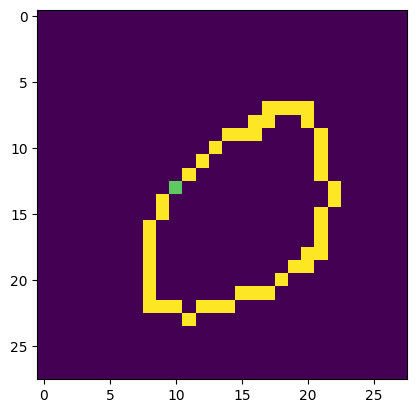

In [52]:
train_data = sorted(train_data, key=lambda f: get_idx(f))
test_data = sorted(test_data, key=lambda f: get_idx(f))

file = train_data[1]
idx = get_idx(file)

print("Index: ", idx, "File:", file, "Label:", train_data[idx])

data = np.genfromtxt(file, delimiter=' ', dtype=int)

print(data)

img = make_img(data)
plt.imshow(img.T)

### Dataset

To turn our array into a torch dataset, we need to efficiently get from an index to a corresponding file/label pair. Since we already got the file list sorted above and have the label list, we won't regenerate those in the dataset. We will take in a list of labels that has already been loaded from the label file and take a list of image file paths that is sorted before in the correct order. This makes the dataset just need to load from a file.

In [44]:
class SeqMNIST(Dataset):
    def __init__(self, labels, data):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = np.genfromtxt(self.data[idx], delimiter=' ', dtype=int)

        return label, img

In [45]:
train_dataset = SeqMNIST(train_labels, train_data)
test_dataset = SeqMNIST(test_labels, test_data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

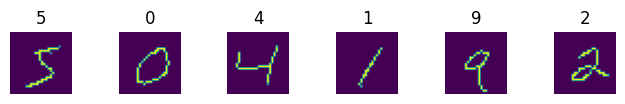

In [54]:
for i, (label, data) in enumerate(train_dataset):
    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('{}'.format(label))
    ax.axis('off')
    img = make_img(data)
    plt.imshow(img.T)

    if i == 5:
        plt.show()
        break

## Model
For the model, because the sequences can be of any lenght, we are using an LSTM. Our model is very simple with only an LSTM layer feeding into a linear and softmax layer that outputs to the 10 classes.

In [7]:
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=10):
        super(LSTMTagger, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers)
        self.hidden2tag = nn.Linear(hidden_size * num_layers, output_size)

    def forward(self, seq):
        lstm_out, _ = self.lstm(seq)[-1]
        lstm_out = torch.flatten(lstm_out)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.softmax(tag_space, dim=0)
        return tag_scores

In [55]:
model = LSTMTagger(4, 32, 6, 10).cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print(model)
print(sum(p.numel() for p in model.parameters()), "trainable parameters")

LSTMTagger(
  (lstm): LSTM(4, 32, num_layers=6)
  (hidden2tag): Linear(in_features=192, out_features=10, bias=True)
)

49034 trainable parameters

## Training
For training, we will save the model every time the validation accuracy increases. I was paranoid of losing the model so I made it save too liberally. So when running this, it saved way too many times and I had to clean my folder of all the random model checkpoints I had.

In [18]:
criterion = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

max_val = 0

for epoch in range(50):
    avg_loss = 0
    correct = 0
    en = tqdm(enumerate(train_loader))
    for step, (label, seq) in en:
        optimizer.zero_grad()
        
        bx = Variable(seq).cuda().squeeze().float()
        output = model(bx)
        
        maxi = torch.argmax(output)
        if maxi.item() == label.item():
            correct += 1
        
        label = label.cuda().squeeze()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        
        en.set_description("{}/{} - Train accuracy {:.4f}".format(step, len(train_loader), correct / (step + 1)))
        
    print("Completed epoch", epoch, "with avg. loss", avg_loss / len(train_loader), "and accuracy", correct / len(train_loader))
    train_loss.append(avg_loss / len(train_loader))
    train_acc.append(correct / len(train_loader))
    
    avg_loss = 0
    correct = 0
    en = tqdm(enumerate(test_loader))
    for step, (label, seq) in en:
        with torch.no_grad():
            bx = Variable(seq).cuda().squeeze().float()
            output = model(bx)
            
            maxi = torch.argmax(output)
            if maxi.item() == label.item():
                correct += 1
            
            label = label.cuda().squeeze()
            loss = criterion(output, label)
            
            en.set_description("{}/{} - Val accuracy {:.4f}".format(step, len(test_loader), correct / (step + 1)))
    
    val_loss.append(avg_loss / len(test_loader))
    val_acc.append(correct / len(test_loader))
    
    if correct / len(test_loader) > max_val:
        max_val = correct / len(test_loader)
        print("Saving checkpoint with", max_val, "accuracy on epoch", epoch)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, "lstm-chk-{}.pt".format(epoch))

59999/60000 - Train accuracy 0.7104: : 60000it [01:44, 573.06it/s]


Completed epoch 0 with avg. loss 1.750279593537251 and accuracy 0.7104333333333334

2594/10000 - Val accuracy 0.7368: : 2572it [00:02, 1107.64it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6489/10000 - Val accuracy 0.7357: : 6488it [00:05, 1065.91it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7387: : 10000it [00:09, 1091.55it/s]


Saving checkpoint with 0.7387 accuracy on epoch 0

327/60000 - Train accuracy 0.7439: : 300it [00:00, 602.18it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.7289: : 60000it [01:41, 591.58it/s]


Completed epoch 1 with avg. loss 1.7314791202465694 and accuracy 0.7288666666666667

2744/10000 - Val accuracy 0.7421: : 2644it [00:02, 1090.71it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6558/10000 - Val accuracy 0.7359: : 6501it [00:06, 1020.56it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7414: : 10000it [00:09, 1065.78it/s]


Saving checkpoint with 0.7414 accuracy on epoch 1

59999/60000 - Train accuracy 0.7323: : 60000it [01:41, 592.66it/s]


Completed epoch 2 with avg. loss 1.7276353992740314 and accuracy 0.7323

2503/10000 - Val accuracy 0.7332: : 2466it [00:02, 1130.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6476/10000 - Val accuracy 0.7442: : 6461it [00:05, 1099.75it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7428: : 10000it [00:09, 1089.95it/s]


Saving checkpoint with 0.7428 accuracy on epoch 2

59999/60000 - Train accuracy 0.6857: : 60000it [01:40, 596.29it/s]


Completed epoch 3 with avg. loss 1.7752614363352457 and accuracy 0.6856666666666666

2721/10000 - Val accuracy 0.7175: : 2678it [00:02, 1025.50it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6510/10000 - Val accuracy 0.7189: : 6407it [00:06, 1123.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7157: : 10000it [00:09, 1070.16it/s]
59999/60000 - Train accuracy 0.6995: : 60000it [01:40, 597.21it/s]


Completed epoch 4 with avg. loss 1.762514460204045 and accuracy 0.6995333333333333

2729/10000 - Val accuracy 0.7355: : 2666it [00:02, 1089.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6626/10000 - Val accuracy 0.7361: : 6581it [00:06, 1104.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7324: : 10000it [00:09, 1086.08it/s]
59999/60000 - Train accuracy 0.7194: : 60000it [01:41, 590.65it/s]


Completed epoch 5 with avg. loss 1.741350176769495 and accuracy 0.71935

2877/10000 - Val accuracy 0.7363: : 2823it [00:02, 1025.85it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6625/10000 - Val accuracy 0.7372: : 6601it [00:06, 1147.47it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7391: : 10000it [00:09, 1083.28it/s]
59999/60000 - Train accuracy 0.7292: : 60000it [01:39, 600.51it/s]


Completed epoch 6 with avg. loss 1.7310317774275938 and accuracy 0.7292166666666666

2489/10000 - Val accuracy 0.7434: : 2445it [00:02, 1060.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6446/10000 - Val accuracy 0.7458: : 6433it [00:05, 1054.07it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7488: : 10000it [00:09, 1085.07it/s]


Saving checkpoint with 0.7488 accuracy on epoch 6

204/60000 - Train accuracy 0.7610: : 183it [00:00, 604.09it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.7306: : 60000it [01:40, 594.94it/s]


Completed epoch 7 with avg. loss 1.7300210184037685 and accuracy 0.7305666666666667

2744/10000 - Val accuracy 0.7293: : 2674it [00:02, 1051.36it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6570/10000 - Val accuracy 0.7443: : 6506it [00:06, 1032.10it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7453: : 10000it [00:09, 1069.70it/s]
59999/60000 - Train accuracy 0.7381: : 60000it [01:41, 591.99it/s]


Completed epoch 8 with avg. loss 1.7220830528815587 and accuracy 0.7381166666666666

2751/10000 - Val accuracy 0.7529: : 2673it [00:02, 1036.70it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6584/10000 - Val accuracy 0.7487: : 6500it [00:06, 1109.88it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7520: : 10000it [00:09, 1083.08it/s]


Saving checkpoint with 0.752 accuracy on epoch 8

59999/60000 - Train accuracy 0.7431: : 60000it [01:41, 593.36it/s]


Completed epoch 9 with avg. loss 1.7170372995853425 and accuracy 0.7430833333333333

2665/10000 - Val accuracy 0.7644: : 2605it [00:02, 1065.48it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6526/10000 - Val accuracy 0.7578: : 6437it [00:06, 1005.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7544: : 10000it [00:09, 1035.27it/s]


Saving checkpoint with 0.7544 accuracy on epoch 9

59999/60000 - Train accuracy 0.7452: : 60000it [01:42, 588.23it/s]


Completed epoch 10 with avg. loss 1.7149940188586712 and accuracy 0.7452166666666666

2461/10000 - Val accuracy 0.7701: : 2407it [00:02, 1165.28it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6497/10000 - Val accuracy 0.7544: : 6403it [00:05, 1018.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7528: : 10000it [00:09, 1087.45it/s]
59999/60000 - Train accuracy 0.7441: : 60000it [01:42, 585.09it/s]


Completed epoch 11 with avg. loss 1.7159738178670407 and accuracy 0.7440833333333333

2733/10000 - Val accuracy 0.7531: : 2669it [00:02, 1109.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6583/10000 - Val accuracy 0.7515: : 6514it [00:06, 1106.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7562: : 10000it [00:09, 1070.08it/s]


Saving checkpoint with 0.7562 accuracy on epoch 11

59999/60000 - Train accuracy 0.7463: : 60000it [01:40, 599.78it/s]


Completed epoch 12 with avg. loss 1.7130692829231422 and accuracy 0.7463333333333333

2455/10000 - Val accuracy 0.7488: : 2432it [00:02, 1168.23it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6509/10000 - Val accuracy 0.7565: : 6442it [00:05, 1120.83it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.7553: : 10000it [00:08, 1138.39it/s]
456/60000 - Train accuracy 0.7155: : 432it [00:00, 607.30it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 13 with avg. loss 1.7004316839953264 and accuracy 0.75905

2583/10000 - Val accuracy 0.8259: : 2559it [00:02, 1176.45it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6549/10000 - Val accuracy 0.8279: : 6473it [00:06, 1076.35it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8304: : 10000it [00:09, 1089.86it/s]


Saving checkpoint with 0.8304 accuracy on epoch 13

275/60000 - Train accuracy 0.8116: : 251it [00:00, 624.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.8272: : 60000it [01:35, 627.75it/s]


Completed epoch 14 with avg. loss 1.633418860967954 and accuracy 0.8271833333333334

2383/10000 - Val accuracy 0.8314: : 2354it [00:02, 1133.40it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6394/10000 - Val accuracy 0.8278: : 6353it [00:05, 1059.59it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8252: : 10000it [00:09, 1107.20it/s]
288/60000 - Train accuracy 0.8166: : 238it [00:00, 592.07it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 15 with avg. loss 1.6306870090603829 and accuracy 0.8296166666666667

2376/10000 - Val accuracy 0.8443: : 2371it [00:02, 1126.84it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6509/10000 - Val accuracy 0.8361: : 6409it [00:05, 1092.16it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8389: : 10000it [00:08, 1156.46it/s]


Saving checkpoint with 0.8389 accuracy on epoch 15

437/60000 - Train accuracy 0.8356: : 395it [00:00, 652.22it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.8317: : 60000it [01:35, 630.82it/s]


Completed epoch 16 with avg. loss 1.62856481068333 and accuracy 0.83165

2335/10000 - Val accuracy 0.8369: : 2257it [00:01, 1191.75it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6411/10000 - Val accuracy 0.8403: : 6322it [00:05, 1101.91it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8407: : 10000it [00:09, 1104.23it/s]


Saving checkpoint with 0.8407 accuracy on epoch 16

59999/60000 - Train accuracy 0.8355: : 60000it [01:35, 629.02it/s]


Completed epoch 17 with avg. loss 1.6243675141175589 and accuracy 0.8354833333333334

2346/10000 - Val accuracy 0.8632: : 2327it [00:02, 1161.93it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6328/10000 - Val accuracy 0.8520: : 6328it [00:05, 1127.96it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8446: : 10000it [00:09, 1082.78it/s]


Saving checkpoint with 0.8446 accuracy on epoch 17

59999/60000 - Train accuracy 0.8364: : 60000it [01:35, 631.06it/s]


Completed epoch 18 with avg. loss 1.6235215257843336 and accuracy 0.8363833333333334

2358/10000 - Val accuracy 0.8504: : 2354it [00:02, 1085.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6447/10000 - Val accuracy 0.8483: : 6378it [00:05, 1158.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8467: : 10000it [00:08, 1137.63it/s]


Saving checkpoint with 0.8467 accuracy on epoch 18

59999/60000 - Train accuracy 0.8381: : 60000it [01:35, 629.43it/s]


Completed epoch 19 with avg. loss 1.6213849420110384 and accuracy 0.8380666666666666

2396/10000 - Val accuracy 0.8515: : 2310it [00:02, 1160.72it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6483/10000 - Val accuracy 0.8495: : 6442it [00:05, 1153.03it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8461: : 10000it [00:08, 1154.70it/s]
59999/60000 - Train accuracy 0.8398: : 60000it [01:35, 627.01it/s]


Completed epoch 20 with avg. loss 1.6197060447295506 and accuracy 0.8397666666666667

2415/10000 - Val accuracy 0.8493: : 2324it [00:02, 1156.71it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6499/10000 - Val accuracy 0.8425: : 6412it [00:05, 1081.24it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8440: : 10000it [00:08, 1119.09it/s]
349/60000 - Train accuracy 0.8343: : 306it [00:00, 619.28it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 21 with avg. loss 1.6183627456426621 and accuracy 0.8416166666666667

2468/10000 - Val accuracy 0.8493: : 2381it [00:02, 1076.59it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6451/10000 - Val accuracy 0.8461: : 6387it [00:05, 1036.82it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8484: : 10000it [00:09, 1103.22it/s]


Saving checkpoint with 0.8484 accuracy on epoch 21

210/60000 - Train accuracy 0.8341: : 184it [00:00, 610.62it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.8347: : 60000it [01:37, 614.28it/s]


Completed epoch 22 with avg. loss 1.6250303433756033 and accuracy 0.8347333333333333

2545/10000 - Val accuracy 0.8429: : 2487it [00:02, 1139.83it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6498/10000 - Val accuracy 0.8392: : 6477it [00:05, 1164.61it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8388: : 10000it [00:08, 1142.86it/s]
523/60000 - Train accuracy 0.8130: : 523it [00:00, 658.10it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 23 with avg. loss 1.6226766069153944 and accuracy 0.83745

2347/10000 - Val accuracy 0.8458: : 2255it [00:02, 1153.59it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6448/10000 - Val accuracy 0.8418: : 6434it [00:05, 1108.98it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8401: : 10000it [00:08, 1160.25it/s]
396/60000 - Train accuracy 0.8136: : 390it [00:00, 646.08it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 24 with avg. loss 1.6240619030356407 and accuracy 0.83565

2602/10000 - Val accuracy 0.8463: : 2540it [00:02, 1051.32it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6469/10000 - Val accuracy 0.8476: : 6398it [00:05, 1210.63it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8442: : 10000it [00:08, 1117.61it/s]
59999/60000 - Train accuracy 0.8399: : 60000it [01:35, 629.87it/s]


Completed epoch 25 with avg. loss 1.6197024987280368 and accuracy 0.83995

2531/10000 - Val accuracy 0.8503: : 2446it [00:02, 1126.93it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6464/10000 - Val accuracy 0.8495: : 6347it [00:05, 1173.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8462: : 10000it [00:08, 1117.86it/s]
59999/60000 - Train accuracy 0.8408: : 60000it [01:33, 638.38it/s]


Completed epoch 26 with avg. loss 1.6187845861256123 and accuracy 0.84085

2334/10000 - Val accuracy 0.8493: : 2230it [00:02, 1179.63it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6367/10000 - Val accuracy 0.8475: : 6356it [00:05, 1196.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8481: : 10000it [00:08, 1157.73it/s]
418/60000 - Train accuracy 0.8640: : 376it [00:00, 616.96it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 27 with avg. loss 1.6186538387993972 and accuracy 0.8411166666666666

2232/10000 - Val accuracy 0.8509: : 2169it [00:01, 1205.47it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6291/10000 - Val accuracy 0.8501: : 6282it [00:05, 1194.90it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8472: : 10000it [00:08, 1192.18it/s]
487/60000 - Train accuracy 0.8566: : 442it [00:00, 627.87it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 28 with avg. loss 1.6175712747236093 and accuracy 0.8418333333333333

2301/10000 - Val accuracy 0.8510: : 2236it [00:01, 1108.27it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6267/10000 - Val accuracy 0.8491: : 6229it [00:05, 1207.11it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8478: : 10000it [00:08, 1145.10it/s]
59999/60000 - Train accuracy 0.8451: : 60000it [01:36, 624.94it/s]


Completed epoch 29 with avg. loss 1.614175270517667 and accuracy 0.8451

2513/10000 - Val accuracy 0.8449: : 2450it [00:02, 1086.65it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6465/10000 - Val accuracy 0.8503: : 6399it [00:05, 1136.37it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8497: : 10000it [00:08, 1128.45it/s]


Saving checkpoint with 0.8497 accuracy on epoch 29

59999/60000 - Train accuracy 0.8466: : 60000it [01:34, 635.48it/s]


Completed epoch 30 with avg. loss 1.6126503144462903 and accuracy 0.8465666666666667

2402/10000 - Val accuracy 0.8564: : 2383it [00:02, 1096.93it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6349/10000 - Val accuracy 0.8509: : 6276it [00:05, 1031.21it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8516: : 10000it [00:09, 1102.33it/s]


Saving checkpoint with 0.8516 accuracy on epoch 30

71/60000 - Train accuracy 0.8889: : 62it [00:00, 615.63it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.8478: : 60000it [01:35, 629.88it/s]


Completed epoch 31 with avg. loss 1.6113394369443257 and accuracy 0.8478166666666667

2478/10000 - Val accuracy 0.8495: : 2454it [00:02, 1121.48it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6477/10000 - Val accuracy 0.8479: : 6387it [00:05, 1117.54it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8482: : 10000it [00:08, 1139.86it/s]
59999/60000 - Train accuracy 0.8469: : 60000it [01:35, 629.44it/s]


Completed epoch 32 with avg. loss 1.6119072218616803 and accuracy 0.8468666666666667

2309/10000 - Val accuracy 0.8489: : 2267it [00:01, 1178.85it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6389/10000 - Val accuracy 0.8466: : 6295it [00:05, 1169.08it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8522: : 10000it [00:08, 1180.69it/s]


Saving checkpoint with 0.8522 accuracy on epoch 32

548/60000 - Train accuracy 0.8616: : 507it [00:00, 628.00it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.8465: : 60000it [01:36, 624.91it/s]


Completed epoch 33 with avg. loss 1.612528181540966 and accuracy 0.8465

2265/10000 - Val accuracy 0.8544: : 2154it [00:01, 1200.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6347/10000 - Val accuracy 0.8524: : 6322it [00:05, 949.49it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8516: : 10000it [00:08, 1118.28it/s]
58/60000 - Train accuracy 0.8983: : 0it [00:00, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid cr

Completed epoch 34 with avg. loss 1.6155676392197609 and accuracy 0.8438

2283/10000 - Val accuracy 0.8336: : 2281it [00:01, 1200.64it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6391/10000 - Val accuracy 0.8453: : 6365it [00:05, 1171.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8469: : 10000it [00:08, 1163.75it/s]
358/60000 - Train accuracy 0.8440: : 337it [00:00, 666.46it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 35 with avg. loss 1.6127104603091875 and accuracy 0.8464166666666667

2364/10000 - Val accuracy 0.8588: : 2283it [00:02, 1051.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6463/10000 - Val accuracy 0.8557: : 6361it [00:05, 1134.30it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8553: : 10000it [00:08, 1145.54it/s]


Saving checkpoint with 0.8553 accuracy on epoch 35

422/60000 - Train accuracy 0.8416: : 384it [00:00, 630.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

59999/60000 - Train accuracy 0.8470: : 60000it [01:35, 631.17it/s]


Completed epoch 36 with avg. loss 1.6121042359073956 and accuracy 0.84705

2300/10000 - Val accuracy 0.8453: : 2257it [00:01, 1161.47it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6371/10000 - Val accuracy 0.8478: : 6265it [00:05, 1173.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8511: : 10000it [00:08, 1179.36it/s]
475/60000 - Train accuracy 0.8424: : 446it [00:00, 625.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 37 with avg. loss 1.6125910160799821 and accuracy 0.8467166666666667

2405/10000 - Val accuracy 0.8682: : 2322it [00:02, 1126.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6355/10000 - Val accuracy 0.8564: : 6251it [00:05, 1140.48it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8538: : 10000it [00:09, 1094.78it/s]
59999/60000 - Train accuracy 0.8466: : 60000it [01:36, 621.40it/s]


Completed epoch 38 with avg. loss 1.6125588835438092 and accuracy 0.8466166666666667

2532/10000 - Val accuracy 0.8523: : 2444it [00:02, 1083.24it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6408/10000 - Val accuracy 0.8530: : 6319it [00:05, 1085.81it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8543: : 10000it [00:09, 1097.09it/s]
287/60000 - Train accuracy 0.8403: : 239it [00:00, 594.22it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 39 with avg. loss 1.6104625609993934 and accuracy 0.8486666666666667

2422/10000 - Val accuracy 0.8477: : 2344it [00:02, 1187.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6542/10000 - Val accuracy 0.8507: : 6485it [00:05, 1176.24it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8521: : 10000it [00:08, 1161.06it/s]
59999/60000 - Train accuracy 0.8448: : 60000it [01:36, 624.89it/s]


Completed epoch 40 with avg. loss 1.6142146536429722 and accuracy 0.84485

2417/10000 - Val accuracy 0.8462: : 2309it [00:02, 1104.86it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6473/10000 - Val accuracy 0.8517: : 6468it [00:05, 1170.68it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8484: : 10000it [00:08, 1164.93it/s]
594/60000 - Train accuracy 0.8504: : 568it [00:00, 630.51it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 41 with avg. loss 1.6114391421337921 and accuracy 0.84725

2418/10000 - Val accuracy 0.8512: : 2338it [00:02, 1129.83it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6518/10000 - Val accuracy 0.8498: : 6507it [00:05, 1137.22it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8527: : 10000it [00:08, 1124.97it/s]
59999/60000 - Train accuracy 0.8443: : 60000it [01:41, 590.70it/s]


Completed epoch 42 with avg. loss 1.6149459957003593 and accuracy 0.8442833333333334

4108/10000 - Val accuracy 0.8532: : 4034it [00:04, 1125.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

8124/10000 - Val accuracy 0.8470: : 8059it [00:07, 1023.43it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8474: : 10000it [00:09, 1021.59it/s]
59999/60000 - Train accuracy 0.8447: : 60000it [01:38, 607.81it/s]


Completed epoch 43 with avg. loss 1.614369627982378 and accuracy 0.8446666666666667

2479/10000 - Val accuracy 0.8460: : 2431it [00:02, 1158.29it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6531/10000 - Val accuracy 0.8471: : 6503it [00:05, 1121.37it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8508: : 10000it [00:08, 1151.38it/s]
59999/60000 - Train accuracy 0.8502: : 60000it [01:37, 618.26it/s]


Completed epoch 44 with avg. loss 1.608908331368367 and accuracy 0.8502166666666666

2499/10000 - Val accuracy 0.8704: : 2418it [00:02, 1154.63it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6544/10000 - Val accuracy 0.8739: : 6485it [00:05, 1144.37it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8788: : 10000it [00:08, 1132.58it/s]


Saving checkpoint with 0.8788 accuracy on epoch 44

59999/60000 - Train accuracy 0.8809: : 60000it [01:37, 612.69it/s]


Completed epoch 45 with avg. loss 1.5792303181151548 and accuracy 0.8809

2543/10000 - Val accuracy 0.8915: : 2530it [00:02, 1073.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6520/10000 - Val accuracy 0.8936: : 6452it [00:05, 1139.46it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.8937: : 10000it [00:08, 1124.06it/s]


Saving checkpoint with 0.8937 accuracy on epoch 45

59999/60000 - Train accuracy 0.9285: : 60000it [01:37, 617.06it/s]


Completed epoch 46 with avg. loss 1.5333966901520888 and accuracy 0.92855

2532/10000 - Val accuracy 0.9317: : 2480it [00:02, 1079.29it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6471/10000 - Val accuracy 0.9325: : 6369it [00:05, 1065.87it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.9353: : 10000it [00:09, 1103.78it/s]


Saving checkpoint with 0.9353 accuracy on epoch 46

59999/60000 - Train accuracy 0.9285: : 60000it [01:38, 608.73it/s]


Completed epoch 47 with avg. loss 1.5328491668363413 and accuracy 0.92855

2496/10000 - Val accuracy 0.9271: : 2399it [00:02, 1116.74it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6522/10000 - Val accuracy 0.9279: : 6451it [00:05, 1127.43it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.9303: : 10000it [00:08, 1144.88it/s]
524/60000 - Train accuracy 0.9219: : 496it [00:00, 613.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 48 with avg. loss 1.5331756910423437 and accuracy 0.9284666666666667

2580/10000 - Val accuracy 0.9326: : 2576it [00:02, 1053.94it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6443/10000 - Val accuracy 0.9226: : 6423it [00:05, 1124.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.9218: : 10000it [00:09, 1103.85it/s]
359/60000 - Train accuracy 0.8833: : 303it [00:00, 582.70it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to 

Completed epoch 49 with avg. loss 1.5360596282263597 and accuracy 0.9253666666666667

2486/10000 - Val accuracy 0.9304: : 2382it [00:02, 1206.14it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

6569/10000 - Val accuracy 0.9274: : 6477it [00:05, 1157.17it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

9999/10000 - Val accuracy 0.9305: : 10000it [00:08, 1140.87it/s]


In [19]:
torch.save(model, 'models/lstm-trained.pt')

In [20]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')